Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3178
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1763
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1541
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1444
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1384
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1345
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1312
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1289
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1273
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1254
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1244
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1230
Epoch 13/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1218
Epoch 14/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1209
Epoch 15/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

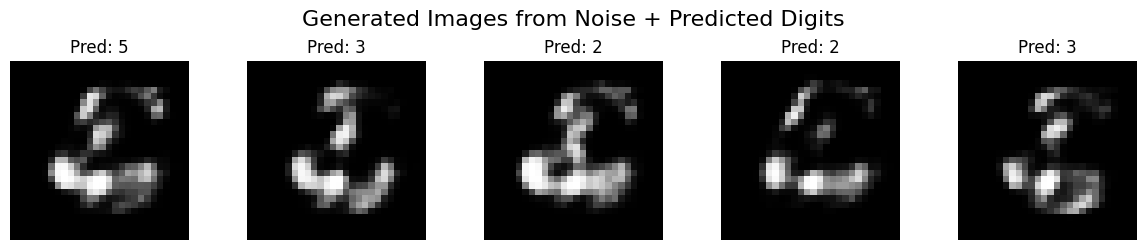

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise to training images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

# Denoising Autoencoder Architecture
latent_dim = 64

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(latent_dim, activation='relu')(x)

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = Dense(256, activation='relu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

# Models
encoder = Model(input_img, encoded, name="Encoder")
decoder = Model(decoder_input, decoded, name="Decoder")

# Full Denoising Autoencoder
autoencoder_input = Input(shape=(28, 28, 1))
encoded_img = encoder(autoencoder_input)
reconstructed_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, reconstructed_img)

# Compile and Train the Denoising Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=256, shuffle=True)

# CNN Classifier (same as before)
input_cls = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_cls)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_cls = Dense(10, activation='softmax')(x)

classifier = Model(inputs=input_cls, outputs=output_cls)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.1)

# Sample Noise Vectors with mean = 5
mean = 5
std_dev = 1
noise_vectors = np.random.normal(loc=mean, scale=std_dev, size=(5, latent_dim))

print("Sampled noise vectors (N({}, {})): \n".format(mean, std_dev))
for i, vec in enumerate(noise_vectors):
    print(f"Noise Vector {i+1}:")
    print(np.round(vec, 2))
    print()

# Generate Images from Decoder
generated_images = decoder.predict(noise_vectors)

# Predict Labels Using Classifier 
predicted_labels = classifier.predict(generated_images)
predicted_digits = np.argmax(predicted_labels, axis=1)

# Display the Generated Images with Predicted Labels
plt.figure(figsize=(12, 2.5))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Pred: {predicted_digits[i]}")
    plt.axis('off')
plt.suptitle("Generated Images from Noise + Predicted Digits", fontsize=16)
plt.tight_layout()
plt.show()
